# Test sampling algorithms

In [1]:
import os
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import scipy.interpolate
import ultraplot as plt
from tqdm import tqdm

import ment

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

Create a particle distribution.

In [3]:
# Settings
ndim = 4
size = 1_000_000
n_modes = 5
seed = 1241

# Create gaussian particle distribution
rng = np.random.default_rng(seed)
mean = np.zeros(ndim)
cov = np.identity(ndim)
for i in range(ndim):
    for j in range(i):
        cov[i, j] = cov[j, i] = rng.uniform(-0.4, 0.4)
x = rng.multivariate_normal(mean, cov, size=size)

# Add gaussian blobs
for _ in range(n_modes):
    scale = rng.uniform(0.8, 1.5, size=ndim)
    loc = rng.uniform(-5.0, 3.0, size=ndim)
    x = np.vstack([x, rng.normal(loc=loc, scale=scale, size=(size // n_modes, ndim))])
x = x - np.mean(x, axis=0)

rng.shuffle(x)

x_true = np.copy(x)

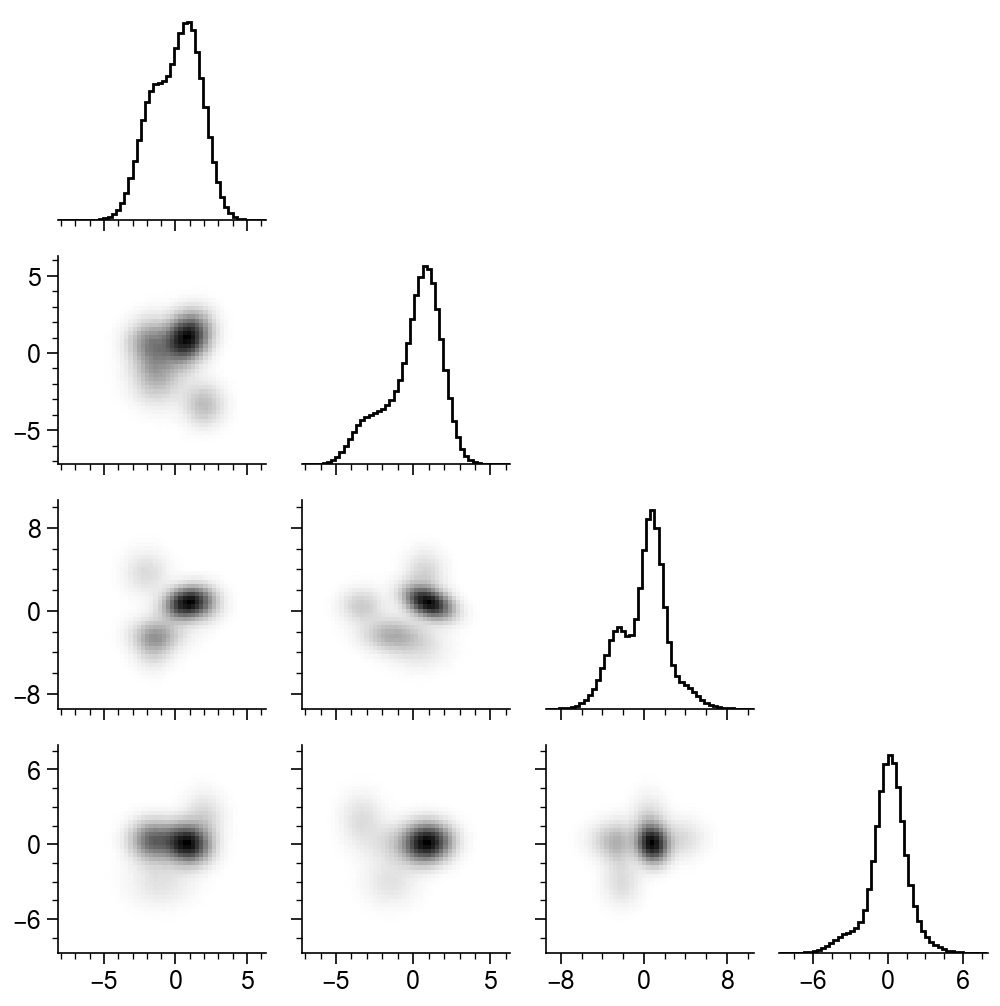

In [4]:
limits = ps.limits(x_true)

grid = psv.CornerGrid(ndim, corner=True, figwidth=(1.25 * ndim))
grid.plot(
    x_true,
    bins=50,
    limits=limits,
    cmap="mono",
)
plt.show()

Compute ground-truth histogram.

In [5]:
n_bins = 25
values, edges = np.histogramdd(x_true, bins=n_bins, range=limits, density=True)
hist = ps.Histogram(values=values, edges=edges)
print("hist.shape =", hist.shape)

hist.shape = (25, 25, 25, 25)


Interpolate to obtain a smooth density function.

In [6]:
prob_func = scipy.interpolate.RegularGridInterpolator(
    hist.coords,
    hist.values,
    method="linear",
    bounds_error=False,
    fill_value=0.0,
)

## Grid Sampling (GS)

In [7]:
samp_grid_res = 15  # limit ~ 15
grid_shape = [samp_grid_res] * ndim
grid_limits = limits

sampler = ment.samp.GridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    noise=0.0,
)

start_time = time.time()
x_samp = sampler(prob_func, size)

print("time:", time.time() - start_time)

time: 0.14806127548217773


Plot a samples over histogram projections.

In [8]:
def plot_corner_samp(x_samp: np.ndarray):
    limits = ps.limits(x_true, rms=2.5)

    grid = psv.CornerGrid(ndim, corner=True, figwidth=(1.25 * ndim))
    grid.set_limits(limits)
    grid.plot_hist(hist, cmap="mono")
    grid.plot(x_samp[:, :], kind="hist", alpha=0.0, diag_kws=dict(color="red"))
    grid.plot(
        x_samp[:1000, :],
        diag=False,
        kind="scatter",
        color="red",
        s=0.25,
    )
    return grid

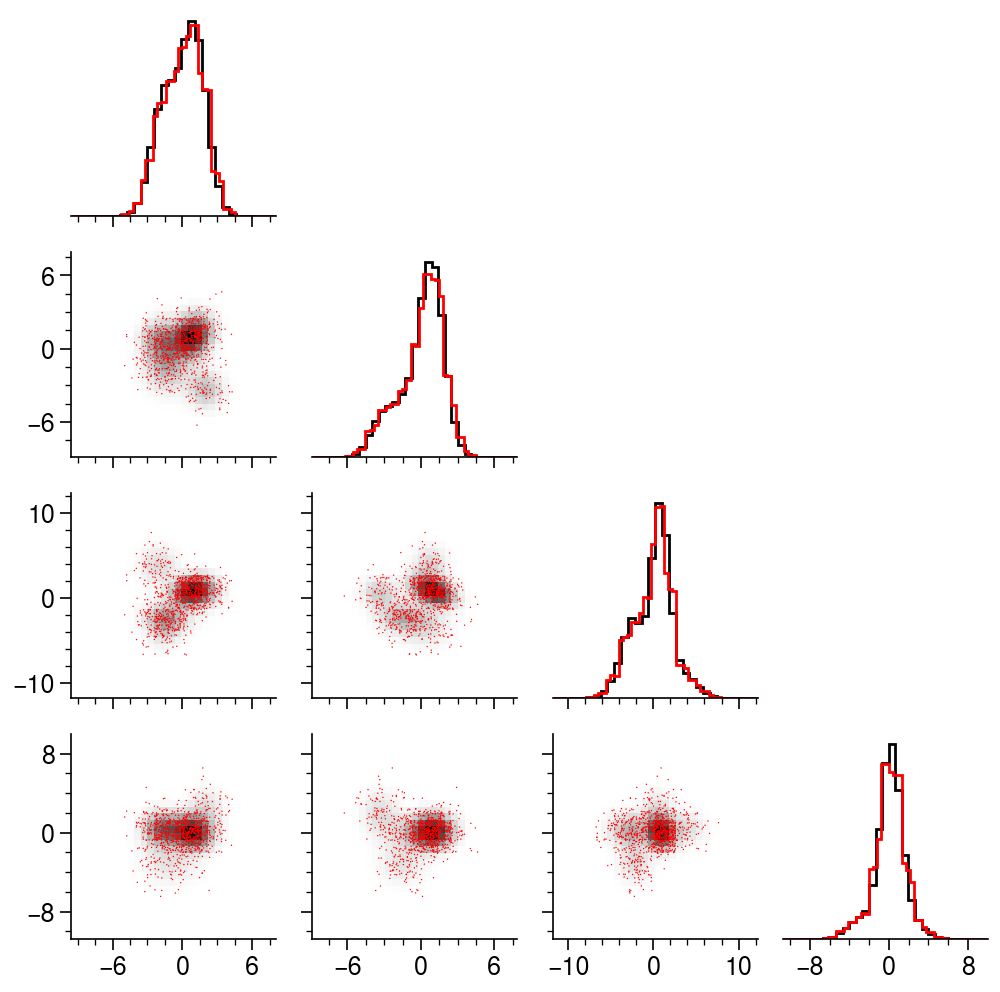

In [9]:
grid = plot_corner_samp(x_samp)

## Slice Grid Sampling (GS)

In [10]:
samp_res = 20
int_res = 10

ndim_proj = 2
ndim_samp = ndim_int = ndim - ndim_proj

grid_shape = [samp_res] * ndim
grid_limits = limits
int_size = int(int_res**ndim_int)

sampler = ment.samp.SliceGridSampler(
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    proj_dim=ndim_proj,
    int_size=int_size,
    int_method="grid",
    int_batches=1,
    noise=0.0,
    verbose=True,
)

start_time = time.time()
x_samp = sampler(prob_func, size)
print("time:", time.time() - start_time)

Projecting


  0%|                                                                                                                                                                 | 0/400 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 10257.97it/s]

Sampling


0it [00:00, ?it/s]

292it [00:00, 2900.48it/s]

400it [00:00, 3337.81it/s]

time:

 0.813845157623291


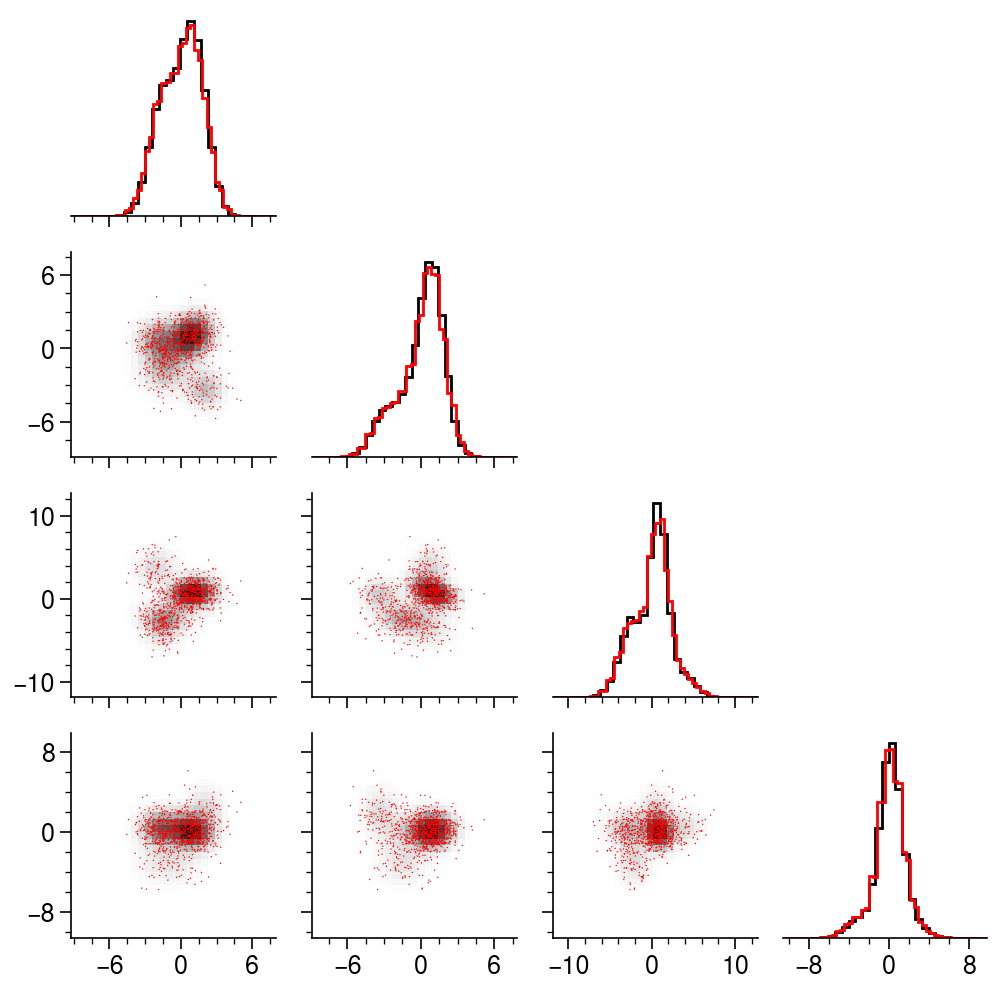

In [11]:
grid = plot_corner_samp(x_samp)

## Metropolis-Hastings

In [12]:
sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=np.eye(ndim),
    start=None,
    chains=1,
    burnin=1_000,
    shuffle=True,
    verbose=True,
)
x_samp = sampler(prob_func, size=100_000)

  0%|                                                                                                                                                              | 0/100999 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                              | 1312/100999 [00:00<00:07, 13114.76it/s]

  3%|███▋                                                                                                                                            | 2624/100999 [00:00<00:07, 12790.84it/s]

  4%|█████▌                                                                                                                                          | 3904/100999 [00:00<00:07, 12714.23it/s]

  5%|███████▍                                                                                                                                        | 5191/100999 [00:00<00:07, 12769.79it/s]

  6%|█████████▎                                                                                                                                      | 6508/100999 [00:00<00:07, 12912.44it/s]

  8%|███████████                                                                                                                                     | 7800/100999 [00:00<00:07, 12685.07it/s]

  9%|████████████▉                                                                                                                                   | 9094/100999 [00:00<00:07, 12765.21it/s]

 10%|██████████████▋                                                                                                                                | 10372/100999 [00:00<00:07, 12285.05it/s]

 12%|████████████████▍                                                                                                                              | 11650/100999 [00:00<00:07, 12432.23it/s]

 13%|██████████████████▎                                                                                                                            | 12911/100999 [00:01<00:07, 12485.55it/s]

 14%|████████████████████                                                                                                                           | 14162/100999 [00:01<00:07, 11996.07it/s]

 15%|█████████████████████▊                                                                                                                         | 15367/100999 [00:01<00:07, 11657.98it/s]

 16%|███████████████████████▍                                                                                                                       | 16538/100999 [00:01<00:07, 11382.48it/s]

 18%|█████████████████████████▏                                                                                                                     | 17802/100999 [00:01<00:07, 11740.42it/s]

 19%|██████████████████████████▊                                                                                                                    | 18981/100999 [00:01<00:07, 11290.07it/s]

 20%|████████████████████████████▋                                                                                                                  | 20258/100999 [00:01<00:06, 11711.03it/s]

 21%|██████████████████████████████▍                                                                                                                | 21507/100999 [00:01<00:06, 11935.34it/s]

 22%|████████████████████████████████▏                                                                                                              | 22706/100999 [00:01<00:06, 11418.62it/s]

 24%|█████████████████████████████████▉                                                                                                             | 23953/100999 [00:01<00:06, 11717.62it/s]

 25%|███████████████████████████████████▋                                                                                                           | 25236/100999 [00:02<00:06, 12037.65it/s]

 26%|█████████████████████████████████████▍                                                                                                         | 26446/100999 [00:02<00:06, 11755.09it/s]

 27%|███████████████████████████████████████                                                                                                        | 27627/100999 [00:02<00:06, 11690.67it/s]

 29%|████████████████████████████████████████▉                                                                                                      | 28898/100999 [00:02<00:06, 11985.69it/s]

 30%|██████████████████████████████████████████▋                                                                                                    | 30162/100999 [00:02<00:05, 12176.92it/s]

 31%|████████████████████████████████████████████▌                                                                                                  | 31447/100999 [00:02<00:05, 12375.13it/s]

 32%|██████████████████████████████████████████████▎                                                                                                | 32687/100999 [00:02<00:05, 11870.06it/s]

 34%|████████████████████████████████████████████████                                                                                               | 33918/100999 [00:02<00:05, 11996.18it/s]

 35%|█████████████████████████████████████████████████▉                                                                                             | 35248/100999 [00:02<00:05, 12375.16it/s]

 36%|███████████████████████████████████████████████████▋                                                                                           | 36518/100999 [00:03<00:05, 12469.28it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                         | 37768/100999 [00:03<00:05, 12347.10it/s]

 39%|███████████████████████████████████████████████████████▏                                                                                       | 39005/100999 [00:03<00:05, 12275.19it/s]

 40%|█████████████████████████████████████████████████████████                                                                                      | 40305/100999 [00:03<00:04, 12487.74it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                    | 41556/100999 [00:03<00:04, 12003.00it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                  | 42815/100999 [00:03<00:04, 12170.39it/s]

 44%|██████████████████████████████████████████████████████████████▍                                                                                | 44066/100999 [00:03<00:04, 12267.56it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                              | 45296/100999 [00:03<00:04, 11560.77it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                             | 46462/100999 [00:03<00:04, 11075.50it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                           | 47603/100999 [00:03<00:04, 11168.16it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                          | 48742/100999 [00:04<00:04, 11230.12it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                        | 49967/100999 [00:04<00:04, 11523.74it/s]

 51%|████████████████████████████████████████████████████████████████████████▌                                                                      | 51245/100999 [00:04<00:04, 11890.70it/s]

 52%|██████████████████████████████████████████████████████████████████████████▏                                                                    | 52439/100999 [00:04<00:04, 11709.36it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                   | 53700/100999 [00:04<00:03, 11969.69it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                 | 54915/100999 [00:04<00:03, 12022.60it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▍                                                               | 56120/100999 [00:04<00:03, 11588.92it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▎                                                             | 57391/100999 [00:04<00:03, 11912.92it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                            | 58587/100999 [00:04<00:03, 11907.57it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                          | 59885/100999 [00:04<00:03, 12221.48it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████▌                                                        | 61110/100999 [00:05<00:03, 12164.58it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 62414/100999 [00:05<00:03, 12420.17it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 63660/100999 [00:05<00:03, 12429.82it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 64905/100999 [00:05<00:03, 11736.30it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 66149/100999 [00:05<00:02, 11937.69it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 67350/100999 [00:05<00:02, 11608.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 68606/100999 [00:05<00:02, 11881.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 69800/100999 [00:05<00:02, 11817.52it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 70986/100999 [00:05<00:02, 11692.14it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 72220/100999 [00:06<00:02, 11880.50it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 73478/100999 [00:06<00:02, 12084.67it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 74778/100999 [00:06<00:02, 12354.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76091/100999 [00:06<00:01, 12582.45it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 77404/100999 [00:06<00:01, 12744.31it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 78680/100999 [00:06<00:01, 12626.11it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 79944/100999 [00:06<00:01, 12608.67it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 81206/100999 [00:06<00:01, 12385.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 82453/100999 [00:06<00:01, 12408.20it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 83744/100999 [00:06<00:01, 12554.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 85052/100999 [00:07<00:01, 12708.01it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 86324/100999 [00:07<00:01, 12694.93it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 87594/100999 [00:07<00:01, 12621.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 88872/100999 [00:07<00:00, 12668.09it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 90140/100999 [00:07<00:00, 12633.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 91437/100999 [00:07<00:00, 12731.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 92733/100999 [00:07<00:00, 12799.21it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 94014/100999 [00:07<00:00, 12773.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 95292/100999 [00:07<00:00, 12668.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 96583/100999 [00:07<00:00, 12738.50it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97867/100999 [00:08<00:00, 12767.93it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 99144/100999 [00:08<00:00, 12660.46it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 100411/100999 [00:08<00:00, 12192.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100999/100999 [00:08<00:00, 12138.00it/s]

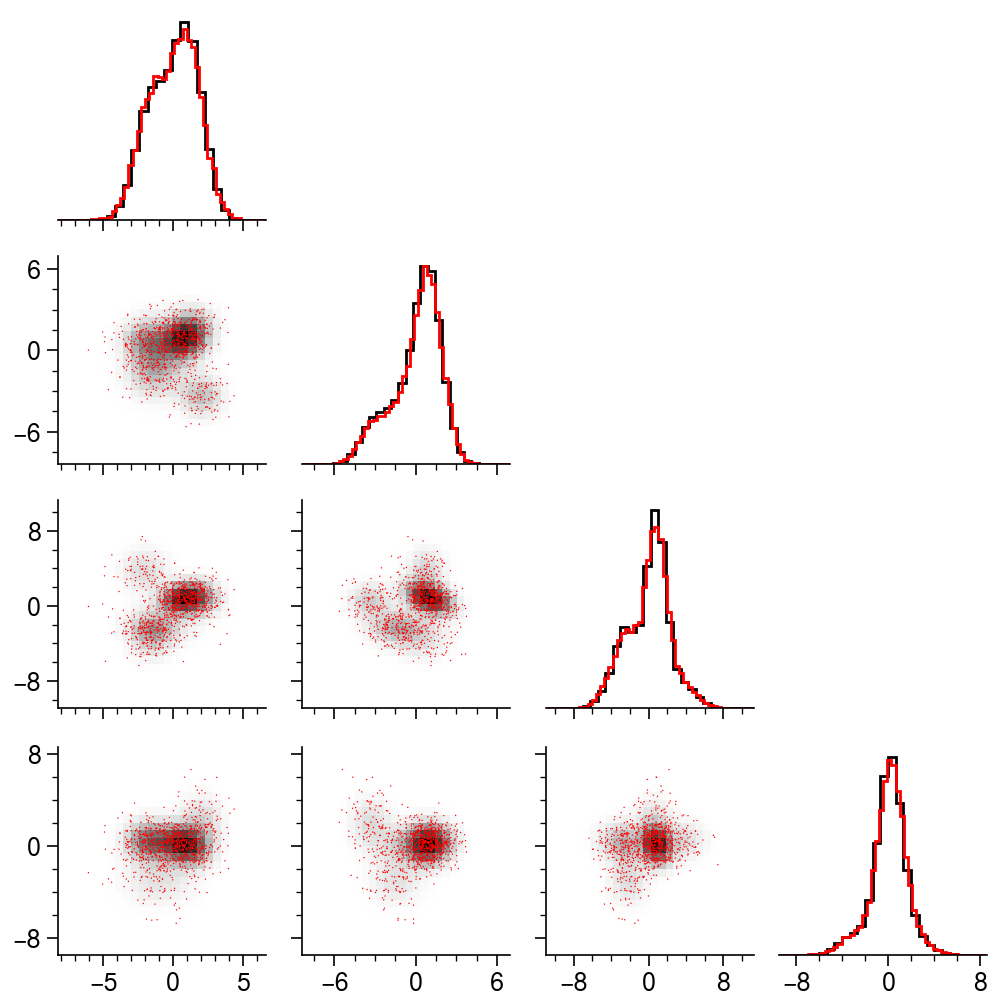

In [13]:
grid = plot_corner_samp(x_samp)

In [14]:
sampler = ment.samp.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=np.eye(ndim),
    start=None,
    chains=10,
    burnin=1_000,
    shuffle=True,
    verbose=True,
)
x_samp = sampler(prob_func, size=100_000)

  0%|                                                                                                                                                               | 0/10999 [00:00<?, ?it/s]

 11%|███████████████▎                                                                                                                                 | 1166/10999 [00:00<00:00, 11650.79it/s]

 21%|██████████████████████████████▋                                                                                                                  | 2332/10999 [00:00<00:00, 11189.68it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 3453/10999 [00:00<00:00, 11046.43it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 4646/10999 [00:00<00:00, 11385.50it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 5856/10999 [00:00<00:00, 11636.48it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7048/10999 [00:00<00:00, 11729.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 8222/10999 [00:00<00:00, 11468.42it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 9371/10999 [00:00<00:00, 11217.26it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 10495/10999 [00:00<00:00, 10570.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10999/10999 [00:01<00:00, 10991.09it/s]

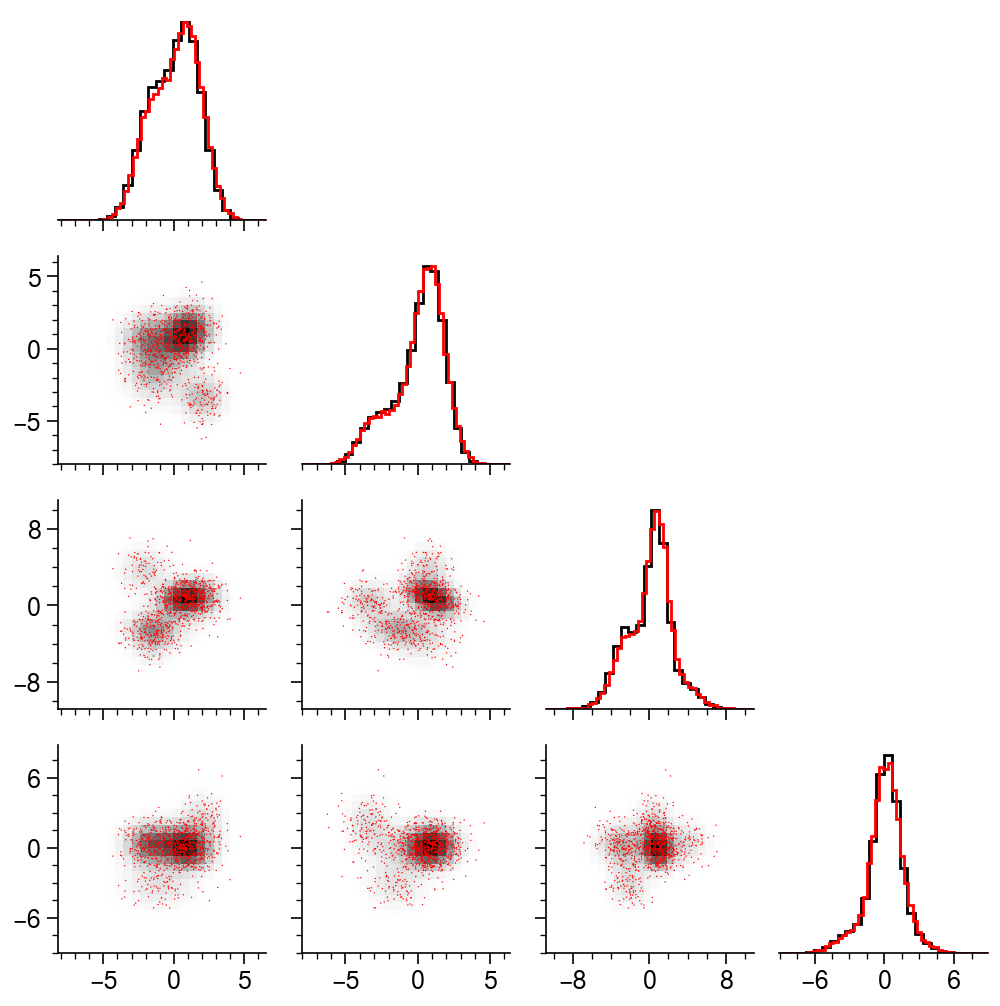

In [15]:
grid = plot_corner_samp(x_samp)